In [69]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime
import math
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)
 
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
plt.style.use("fivethirtyeight")

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200


In [70]:
# MetaTrader5 login credentials
login = 61230237
password = '=opliInyg9'
server = 'Pepperstone-Demo'

mt5.login(login,password,server)

True

In [71]:
# Fetch historical gold prices
date_from=datetime.datetime(2023, 1, 1)
date_to=datetime.datetime.today()
ticker_symbol="EURUSD"
rates=mt5.copy_rates_range(ticker_symbol, mt5.TIMEFRAME_H1, date_from, date_to)

In [72]:
# Create a new datetime column from the time column in unix_timestamps
gold_hist=pd.DataFrame(rates)
gold_hist['Time']=pd.to_datetime(gold_hist['time'], unit="s")
gold_hist=gold_hist.drop(columns=['time', 'real_volume'])

In [73]:
# Reindex the column
new_column_order = ['Time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread']
gold_hist = gold_hist.reindex(columns=new_column_order)
gold_hist.head()

,Time,open,high,low,close,tick_volume,spread
0,2023-01-02 01:00:00,1.06967,1.06983,1.06927,1.06983,174,102
1,2023-01-02 02:00:00,1.06984,1.07059,1.06914,1.07041,172,41
2,2023-01-02 03:00:00,1.07059,1.07069,1.06858,1.06910,228,40
3,2023-01-02 04:00:00,1.06909,1.06909,1.06828,1.06880,105,62
4,2023-01-02 05:00:00,1.06881,1.07029,1.06880,1.06897,82,7


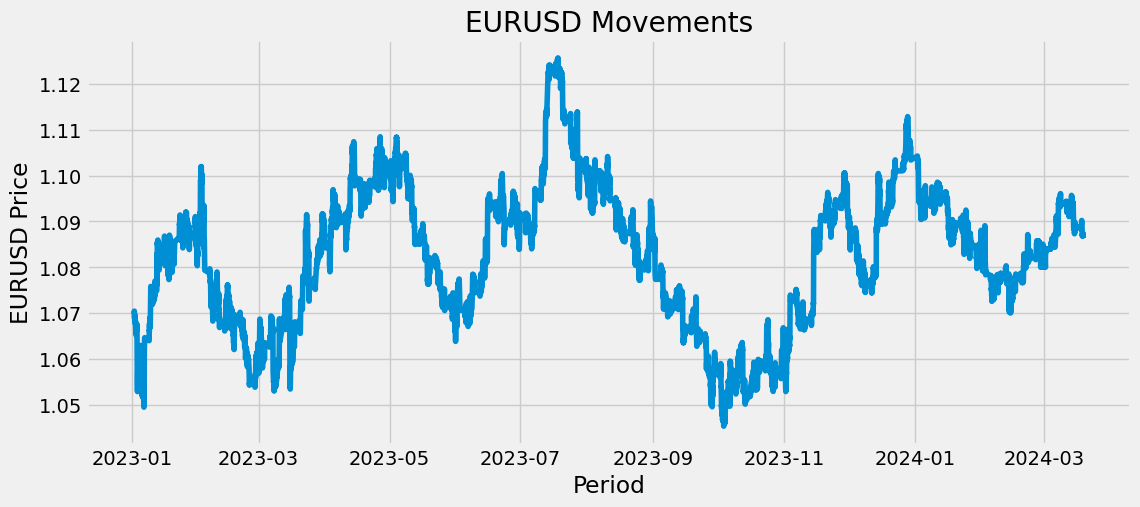

In [74]:
# Plot the Gold price movements
plt.figure(figsize=(12, 5))
plt.plot(gold_hist['Time'], gold_hist['close'], label=f'Closing {ticker_symbol} Movement')
plt.xlabel("Period")
plt.ylabel(f"{ticker_symbol} Price")
plt.title(f"{ticker_symbol} Movements");

In [75]:
data = gold_hist.filter(['close'])
data_2 = gold_hist.filter(['close']).values
train_len = math.ceil(len(data)*0.8)

In [76]:
#Scale the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.30524484],
       [0.31245339],
       [0.29617201],
       ...,
       [0.52336565],
       [0.51938852],
       [0.51143425]])

In [77]:
#Training Data
train_data = scaled_data[:train_len]
x_train = []
y_train = []

for i in range(120, len(train_data)):
  x_train.append(train_data[i-120:i, 0])
  y_train.append(train_data[i, 0])
  if i<=120:
    print(x_train)
    print(y_train)


[array([0.30524484, 0.31245339, 0.29617201, 0.29244345, 0.2945563 ,
       0.30362913, 0.29741486, 0.28970917, 0.28051206, 0.28212777,
       0.28076063, 0.28660204, 0.28796918, 0.2852349 , 0.27989063,
       0.27293065, 0.25789212, 0.25167785, 0.25751926, 0.24807358,
       0.25279642, 0.25863783, 0.25689784, 0.26348496, 0.27827492,
       0.27069351, 0.25739498, 0.27815063, 0.27305493, 0.26671638,
       0.26199354, 0.24819786, 0.21252796, 0.12304251, 0.11782252,
       0.09731544, 0.09395973, 0.10290828, 0.13360676, 0.15075814,
       0.12764106, 0.13087248, 0.11620681, 0.12913249, 0.14118817,
       0.12279393, 0.11918966, 0.11720109, 0.11533681, 0.13087248,
       0.14180959, 0.13944817, 0.1442953 , 0.149391  , 0.14479244,
       0.14578673, 0.17524236, 0.20258514, 0.19624658, 0.2087994 ,
       0.18854089, 0.19214517, 0.19599801, 0.21302511, 0.18692518,
       0.20656227, 0.19202088, 0.18120805, 0.18990803, 0.18729804,
       0.18742232, 0.18965946, 0.19090231, 0.21923937, 0.2083

In [78]:
#convert the x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape training data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(5915, 120, 1)

In [79]:
#Build Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Users\Vincent Gesanda\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [81]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

5915/5915 ━━━━━━━━━━━━━━━━━━━━ 275s 46ms/step - loss: 0.0040


In [87]:
#create the testing data
test_data = scaled_data[train_len-120: , :]
#create x_test and y_test
x_test = []
y_test = data_2[train_len:, : ]

for i in range(120, len(test_data)):
  x_test.append(test_data[i-120:i, 0])

In [88]:
#Convert test data to numpy arrays and reshape
x_test = np.array(x_test)
bx_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [89]:
#model predictions
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


In [90]:
#RSME
rsme = np.sqrt(np.mean(predict-y_test)**2)
rsme

0.00098489525767157

C:\Users\Vincent Gesanda\AppData\Local\Temp\ipykernel_3800\2413835962.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predict


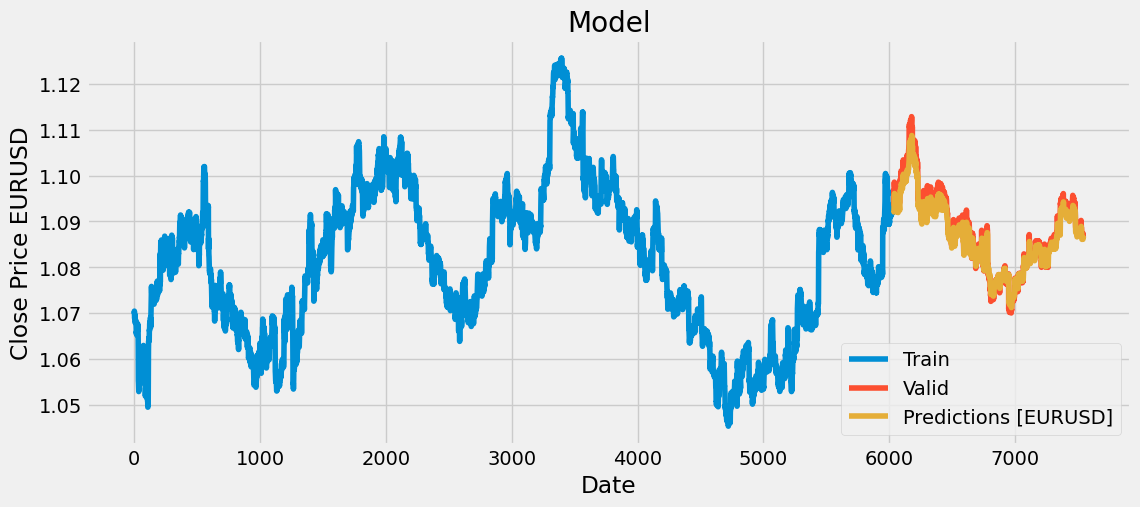

In [91]:
#plot the data
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predict
#visualize the data
plt.figure(figsize=(12, 5))
plt.title('Model')
plt.ylabel(f"Close Price {ticker_symbol[:6]}")
plt.xlabel("Date")
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Valid', f'Predictions [{ticker_symbol[:6]}]'], loc='lower right');